In [1]:
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES']='7'
from matplotlib import pyplot
import shutil
import numpy as np
from six import text_type
import skimage.io
import skimage.transform
from matplotlib import pyplot
import urllib2

import tensorflow as tf
from models import mobilenet_lib

from caffe2.proto import caffe2_pb2
from caffe2.python import core, model_helper, workspace, brew, net_drawer, visualize, utils
import caffe2.python.predictor.predictor_exporter as pe
core.GlobalInit(["caffe2", "--caffe2-log-level=1"])

IMAGE_LOCATION = "https://cdn.pixabay.com/photo/2015/02/10/21/28/flower-631765_1280.jpg"
c2_init_net_file = "mobilenet_caffe2_init_net.pb"
c2_predict_net_file = "mobilenet_caffe2_predict_net.pb"
tf_ckpt = "examples/mobilenets-tensorflow-ckpt/model.ckpt"

In [2]:
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def rescale(img, input_height, input_width):
    print("Original image shape:" + str(img.shape) + " and remember it should be in H, W, C!")
    print("Model's input shape is %dx%d") % (input_height, input_width)
    aspect = img.shape[1]/float(img.shape[0])
    print("Orginal aspect ratio: " + str(aspect))
    if(aspect>1):
        # landscape orientation - wide image
        res = int(aspect * input_height)
        imgScaled = skimage.transform.resize(img, (input_width, res))
    if(aspect<1):
        # portrait orientation - tall image
        res = int(input_width/aspect)
        imgScaled = skimage.transform.resize(img, (res, input_height))
    if(aspect == 1):
        imgScaled = skimage.transform.resize(img, (input_width, input_height))
    pyplot.figure()
    pyplot.imshow(imgScaled)
    pyplot.axis('on')
    pyplot.title('Rescaled image')
    print("New image shape:" + str(imgScaled.shape) + " in HWC")
    return imgScaled

Original image shape:(751, 1280, 3) and remember it should be in H, W, C!
Model's input shape is 160x160
Orginal aspect ratio: 1.70439414115
New image shape:(160, 272, 3) in HWC
After crop:  (160, 160, 3)
NCHW:  (1, 3, 160, 160)
NHWC:  (1, 160, 160, 3)


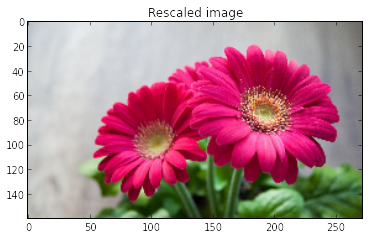

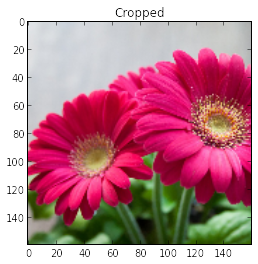

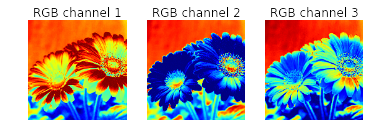

In [3]:
INPUT_IMAGE_SIZE = 160
# load and transform image
img = skimage.img_as_float(skimage.io.imread(IMAGE_LOCATION)).astype(np.float32)
img = rescale(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
img = crop_center(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
print "After crop: " , img.shape
pyplot.figure()
pyplot.imshow(img)
pyplot.axis('on')
pyplot.title('Cropped')

# switch to CHW
img = img.swapaxes(1, 2).swapaxes(0, 1)
pyplot.figure()
for i in range(3):
    # For some reason, pyplot subplot follows Matlab's indexing
    # convention (starting with 1). Well, we'll just follow it...
    pyplot.subplot(1, 3, i+1)
    pyplot.imshow(img[i])
    pyplot.axis('off')
    pyplot.title('RGB channel %d' % (i+1))

# switch to BGR
img = img[(2, 1, 0), :, :]
img_tf = img[:, :, :]

# add batch size
img = img[np.newaxis, :, :, :].astype(np.float32)
print "NCHW: ", img.shape
img_tf = img_tf[np.newaxis, :, :, :].astype(np.float32)
img_tf = img_tf.swapaxes(1, 2).swapaxes(2, 3)
print "NHWC: ", img_tf.shape

In [4]:
init_net_serial = None
predict_net_serial = None
with open(c2_init_net_file, "r") as file_in:
    init_net_serial = file_in.read()
with open(c2_predict_net_file, "r") as file_in:
    predict_net_serial = file_in.read()

init_net = caffe2_pb2.NetDef()
init_net.ParseFromString(init_net_serial)
predict_net = caffe2_pb2.NetDef()
predict_net.ParseFromString(predict_net_serial)

workspace.ResetWorkspace()
workspace.RunNetOnce(init_net)
workspace.FeedBlob("data", img)
workspace.CreateNet(predict_net, True)
workspace.RunNet(predict_net.name)

True

In [5]:
graph = tf.Graph()
sess = tf.Session(graph=graph)

with graph.as_default():
    mobilenet_func = mobilenet_lib.mobilenet_factory(depth_multiplier=0.5, default_image_size=160, scope="MobilenetV1")
    input_data = tf.placeholder(tf.float32, shape=(1, 160, 160, 3))
    logit, end_points = mobilenet_func(input_data, 3, False)
    
    saver = tf.train.Saver()
    saver.restore(sess, tf_ckpt)

    for i in range(1, 14):
        
        print "After pointwise %d:" %(i)
        tensor_pw_relu = tf.get_default_graph().get_tensor_by_name("MobilenetV1/MobilenetV1/Conv2d_%d_pointwise/Relu:0" %(i))
        tensor = sess.run([tensor_pw_relu], feed_dict={input_data: img_tf})
        
        print "tf %d:" %(i)
        print tensor[0].shape
        print tensor[0][0, 0:5, 0:5, 8]
        
        tensor_c2 = workspace.FetchBlob("pointwise%d_relu" %(i))
        print "c2 %d:" %(i)
        print tensor_c2.shape
        print tensor_c2[0, 8, 0:5, 0:5]
        
        print "---------------------------------"
    
    print "After average pooling:"
    tensor_ap = tf.get_default_graph().get_tensor_by_name("MobilenetV1/Logits/AvgPool_1a/AvgPool:0")
    tensor_ap = sess.run([tensor_ap], feed_dict={input_data: img_tf})
    print "tf :"
    print tensor_ap[0].shape
    print tensor_ap[0][0, 0, 0, 0:100]
    
    tensor_c2 = workspace.FetchBlob("average_pool")
    print tensor_c2.shape
    print tensor_c2[0, 0:100, 0, 0]
    
    for i in range(tensor_c2.shape[1]):
        if tensor_ap[0][0, :, :, i] - tensor_c2[0, i, :, :] > 1e-6:
            print tensor_ap[0][0, :, :, i], tensor_c2[0, i, :, :], i

    print "---------------------------------"
    print "After final convolution:"
    tensor_fc = tf.get_default_graph().get_tensor_by_name("MobilenetV1/Logits/Conv2d_1c_1x1/BiasAdd:0")
    tensor_fc = sess.run([tensor_fc], feed_dict={input_data: img_tf})
    print "tf :"
    print tensor_fc[0].shape
    print tensor_fc[0]
    
    print "c2 :"
    tensor_c2 = workspace.FetchBlob("conv_final")
    print tensor_c2.shape
    print tensor_c2
    
    print "---------------------------------"
    print "After softmax:"
    tensor_sm = tf.get_default_graph().get_tensor_by_name("MobilenetV1/Predictions/Softmax:0")
    tensor_sm = sess.run([tensor_sm], feed_dict={input_data: img_tf})
    print "tf :"
    print tensor_sm[0].shape
    print tensor_sm[0]
    
    print "c2 :"
    tensor_c2 = workspace.FetchBlob("softmax")
    print tensor_c2.shape
    print tensor_c2

INFO:tensorflow:Restoring parameters from examples/mobilenets-tensorflow-ckpt/model.ckpt
After pointwise 1:
tf 1:
(1, 80, 80, 32)
[[ 0.91037631  0.80295873  0.77911425  0.81529093  0.85107565]
 [ 0.          0.          0.09031868  0.01748419  0.00781393]
 [ 0.05972338  0.          0.092484    0.06138992  0.        ]
 [ 0.05972195  0.08867073  0.          0.          0.        ]
 [ 0.          0.          0.09608126  0.14011431  0.        ]]
c2 1:
(1, 32, 80, 80)
[[ 0.91037607  0.80295897  0.77911353  0.81529093  0.85107565]
 [ 0.          0.          0.0903182   0.01748371  0.00781345]
 [ 0.05972338  0.          0.09248447  0.06138992  0.        ]
 [ 0.05972242  0.08866978  0.          0.          0.        ]
 [ 0.          0.          0.09608126  0.14011526  0.        ]]
---------------------------------
After pointwise 2:
tf 2:
(1, 40, 40, 64)
[[ 1.50339556  1.11668921  1.22134352  1.09609365  1.01234293]
 [ 0.76459432  0.52410436  0.65055037  0.59198761  0.43104804]
 [ 0.8171711   

In [6]:
workspace.ResetWorkspace()
p = workspace.Predictor(init_net_serial, predict_net_serial)
results = p.run([img])
print results

[array([[[[ 0.04945434]],

        [[ 0.08457877]],

        [[ 0.86596686]]]], dtype=float32)]


In [7]:
# # get all node name
# with graph.as_default():
#     nodes_lst = [n.name for n in tf.get_default_graph().as_graph_def().node]
#     for i in nodes_lst:
#         print i